In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib

%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
raw_df = pd.read_csv('data/kobe.csv')

In [188]:
raw_df.head().T

,1,2,3,4,5
action_type,Jump Shot,Jump Shot,Jump Shot,Driving Dunk Shot,Jump Shot
game_id,20000012,20000012,20000012,20000012,20000012
loc_x,-157,-101,138,0,-145
loc_y,0,135,175,0,-11
period,1,1,1,2,3
playoffs,0,0,0,0,0
season,2000-01,2000-01,2000-01,2000-01,2000-01
shot_made_flag,0,1,0,1,0
shot_type,2PT Field Goal,2PT Field Goal,2PT Field Goal,2PT Field Goal,2PT Field Goal
opponent,POR,POR,POR,POR,POR


In [4]:
# целевая переменная
target = 'shot_made_flag'

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

Данные отсутствуют только для столбца 'shot_made_flag'. Т.к. это целевая переменная, то удаляем все наблюдения с отсутствующим значением.

In [6]:
raw_df.dropna(inplace=True)

In [7]:
# Подсчет количества бросков по типам
raw_df['action_type'].value_counts(dropna=False)

Jump Shot                          15836
Layup Shot                          2154
Driving Layup Shot                  1628
Turnaround Jump Shot                 891
Fadeaway Jump Shot                   872
Running Jump Shot                    779
Pullup Jump shot                     402
Turnaround Fadeaway shot             366
Slam Dunk Shot                       334
Reverse Layup Shot                   333
Jump Bank Shot                       289
Driving Dunk Shot                    257
Dunk Shot                            217
Tip Shot                             151
Step Back Jump shot                  106
Alley Oop Dunk Shot                   95
Floating Jump shot                    93
Driving Reverse Layup Shot            83
Hook Shot                             73
Driving Finger Roll Shot              68
Alley Oop Layup shot                  67
Reverse Dunk Shot                     61
Driving Finger Roll Layup Shot        59
Turnaround Bank shot                  58
Running Layup Sh

In [8]:
# Найдем самые редкие виды бросков
count_action_type = raw_df['action_type'].value_counts()
rare_action_type = set(count_action_type[count_action_type<10].index)
rare_action_type

{'Cutting Layup Shot',
 'Driving Bank shot',
 'Driving Floating Bank Jump Shot',
 'Driving Floating Jump Shot',
 'Hook Bank Shot',
 'Putback Dunk Shot',
 'Putback Layup Shot',
 'Putback Slam Dunk Shot',
 'Running Finger Roll Layup Shot',
 'Running Finger Roll Shot',
 'Running Pull-Up Jump Shot',
 'Running Reverse Layup Shot',
 'Running Slam Dunk Shot',
 'Running Tip Shot',
 'Tip Layup Shot',
 'Turnaround Finger Roll Shot',
 'Turnaround Hook Shot'}

In [9]:
# Переведем редкие виды бросков (кол-во < 10) в категорию 'Other_action_type'
raw_df.loc[raw_df['action_type'].isin(rare_action_type), 'action_type'] = 'Other_action_type'

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
# Создадим стратифицированную выборку обучающего и тестового набора

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, 
                               random_state=42)
for train_index, test_index in split.split(raw_df, raw_df['action_type']):
    train_df = raw_df.iloc[train_index]
    test_df = raw_df.iloc[test_index]

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20557 entries, 7522 to 28079
Data columns (total 25 columns):
action_type           20557 non-null object
combined_shot_type    20557 non-null object
game_event_id         20557 non-null int64
game_id               20557 non-null int64
lat                   20557 non-null float64
loc_x                 20557 non-null int64
loc_y                 20557 non-null int64
lon                   20557 non-null float64
minutes_remaining     20557 non-null int64
period                20557 non-null int64
playoffs              20557 non-null int64
season                20557 non-null object
seconds_remaining     20557 non-null int64
shot_distance         20557 non-null int64
shot_made_flag        20557 non-null float64
shot_type             20557 non-null object
shot_zone_area        20557 non-null object
shot_zone_basic       20557 non-null object
shot_zone_range       20557 non-null object
team_id               20557 non-null int64
team_name      

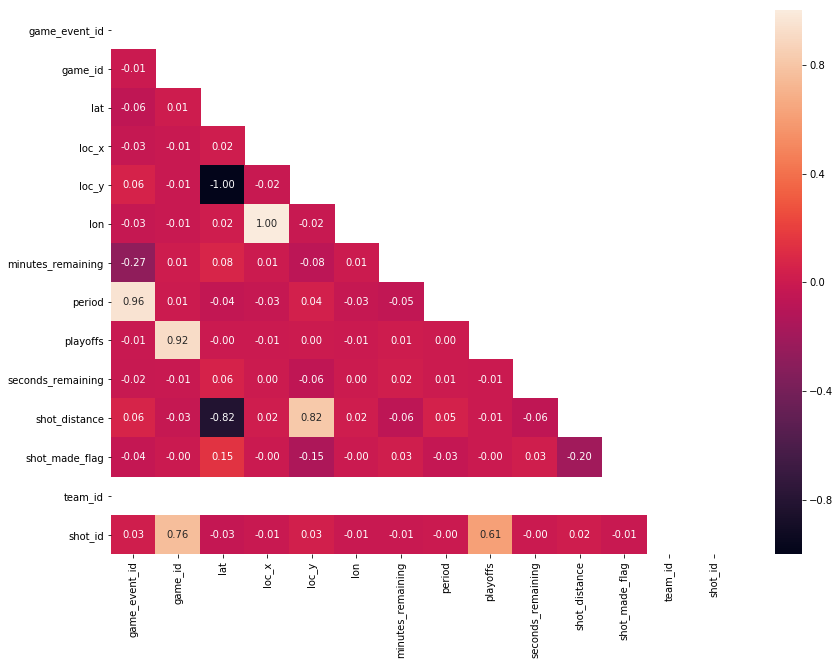

In [13]:
# Посмотрим на корреляцию признаков
corr = raw_df.corr()

plt.figure(figsize = (14,10))

mask = np.triu(np.ones((len(corr), len(corr))), k=0)

sns.heatmap(corr, annot=True, mask = mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            fmt=".2f"
           )

Признаки 'lat' и 'lon' коррелируют с loc_x и loc_y. Эти признаки можно удалить. Также удалим еще несколько ненужных признаков.

In [14]:
cols_to_drop = [
    'game_event_id', 'lat', 
    'lon', 'team_id', 'team_name', 
    'shot_id', 'combined_shot_type',
]

In [15]:
raw_df.drop(cols_to_drop, inplace=True, axis=1, errors='ignore')

In [16]:
raw_df.columns

Index(['action_type', 'game_id', 'loc_x', 'loc_y', 'minutes_remaining',
       'period', 'playoffs', 'season', 'seconds_remaining', 'shot_distance',
       'shot_made_flag', 'shot_type', 'shot_zone_area', 'shot_zone_basic',
       'shot_zone_range', 'game_date', 'matchup', 'opponent'],
      dtype='object')

Создадим новые признаки

In [17]:
def new_columns(df):
    # В признаке 'matchup' содержится информация о том, где проводился
    # матч: дома или в гостях. Это может влиять на результативность.
    df['home'] = df['matchup'].apply(lambda x: int('vs.' in x))
    # Оствшееся до конца периода время разделено на минуты и секунды. Переведем его в секунды.
    df['total_seconds_remaining'] = df['minutes_remaining']*60 + df['seconds_remaining']
    # Разделим поле на зоны по 3-м имеющимся признакам.
    df['field_zones'] = df['shot_zone_area'] + ' ' + df['shot_zone_basic'] + ' ' + df['shot_zone_range']
    # Посмотрим, меняется ли результативность в зависимости от месяца (в теории в начале и конце
    # сезона результативность может быть разной)
    df['month'] = df['game_date'].apply(lambda x: x[5:7])
    df['year'] = df['game_date'].apply(lambda x: x[:4])
    # Переведем координаты x и y в полярные координаты (угол и радиус)
    df['alpha'] = np.arctan2(df['loc_y'], (df['loc_x'] + 0.00001))
    df['radius'] = np.sqrt(df['loc_y']**2 + df['loc_x']**2)
    # Попробуем разбивку поля по квадратам 20х20
    df['x20'] = df['loc_x']//20*20
    df['y20'] = df['loc_y']//20*20
    # Для второй половины поля будет отдельная зона
    df['x20'].where(df['y20'] < 400, 0, inplace=True)
    df['y20'].where(df['y20'] < 400, 400, inplace=True)
    df['xy_zones'] = df[['x20', 'y20']].apply(lambda x: (x[0], x[1]), axis=1)
    # Попробуем разбивку поля по угловым сегментам, используя полярные координаты
    df['alpha_round'] = df['alpha']*40//20/2
    df['radius_50'] = df['radius']//50*50
    df['radius_50'].where(df['radius_50'] < 300, 300, inplace=True)
    df['polar_zones'] = df[['alpha_round', 'radius_50']].apply(lambda x: (x[0], x[1]), axis=1)
    # Для каждой из разбивок поля (по зонам, по xy, по углу и радиусу) подсчитаем результативность
    # в каждой из зон
    for col in ['field_zones', 'xy_zones', 'polar_zones']:
        accuracy_df = np.round(
            df[df[target]==1][[col, target]].groupby(col).count()
            /
            df[[col, target]].groupby(col).count(), 2)
        accuracy_df.fillna(0, inplace=True)
        accuracy_dict = accuracy_df.to_dict()[target]
        df[col+'_accuracy'] = df[col].map(accuracy_dict)
    # Точность в последние секунды гораздо ниже, чем средняя (рассмотрено ниже)
    df['last_seconds'] = df['total_seconds_remaining'].apply(lambda x: x<=3)

In [18]:
new_columns(raw_df)

In [19]:
train_df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

Удалим еще несколько признаков

In [20]:
cols_to_drop = [
    'minutes_remaining', 'seconds_remaining', 
    'shot_distance', 'shot_zone_area', 
    'shot_zone_basic', 'shot_zone_range',
    'game_date', 'matchup', 
]

In [21]:
raw_df.drop(cols_to_drop, inplace=True, axis=1, errors='ignore')
train_df = raw_df.iloc[train_index]
test_df = raw_df.iloc[test_index]

Посмотрим на относительную точность бросков в зависимости от зоны на поле

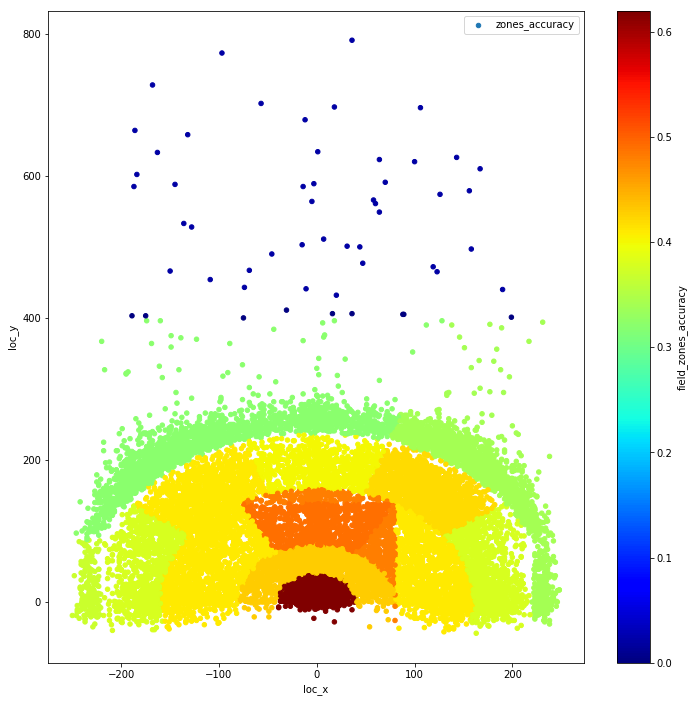

In [22]:
train_df.plot(kind="scatter", x="loc_x", y="loc_y",
    label="zones_accuracy", figsize=(12,12),
    c="field_zones_accuracy", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

С правой стороны точность немного выше.

Посмотрим на относительную точность бросков в зависимости от зоны xy

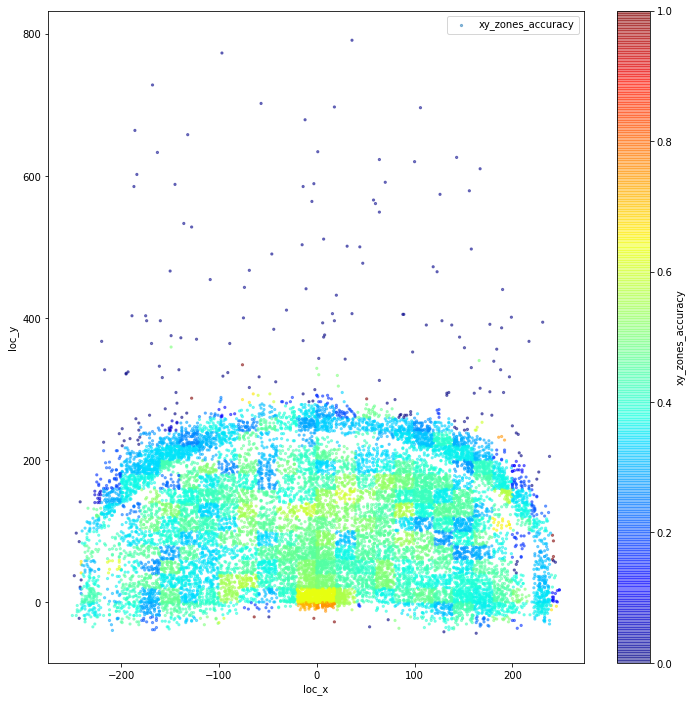

In [23]:
train_df.plot(kind="scatter", x="loc_x", y="loc_y",
    label='xy_zones_accuracy', figsize=(12,12), s =5, alpha=0.5,
    c='xy_zones_accuracy', cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

Посмотрим на относительную точность бросков для сегментов.

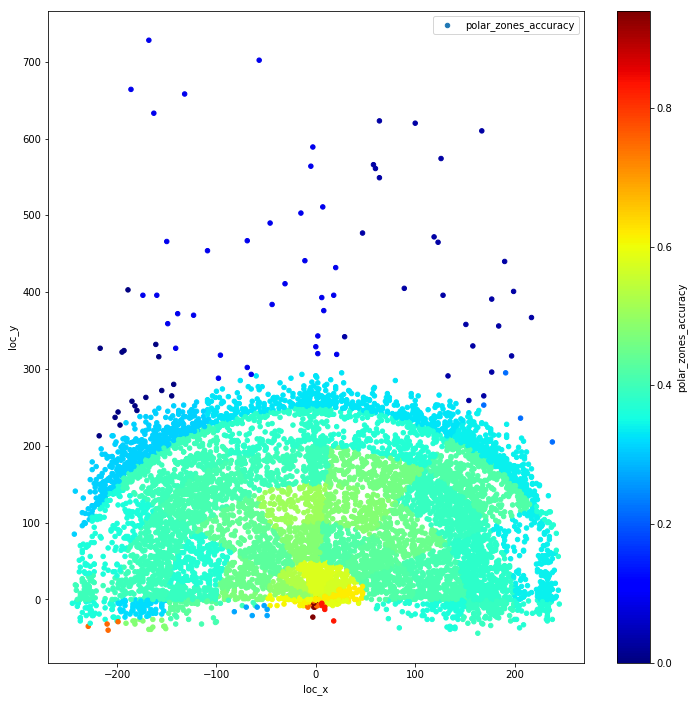

In [24]:
train_df[train_df['home']==0].plot(kind="scatter", x="loc_x", y="loc_y",
    label='polar_zones_accuracy', figsize=(12,12), s =20,
    c='polar_zones_accuracy', cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [25]:
train_df.columns

Index(['action_type', 'game_id', 'loc_x', 'loc_y', 'period', 'playoffs',
       'season', 'shot_made_flag', 'shot_type', 'opponent', 'home',
       'total_seconds_remaining', 'field_zones', 'month', 'year', 'alpha',
       'radius', 'x20', 'y20', 'xy_zones', 'alpha_round', 'radius_50',
       'polar_zones', 'field_zones_accuracy', 'xy_zones_accuracy',
       'polar_zones_accuracy', 'last_seconds'],
      dtype='object')

Посмотрим на распределение относительной точности для различных группировок признаков.

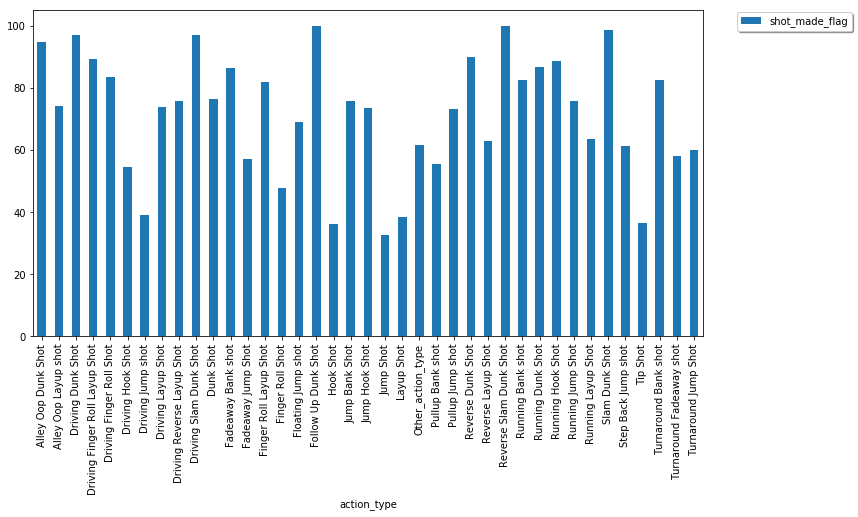

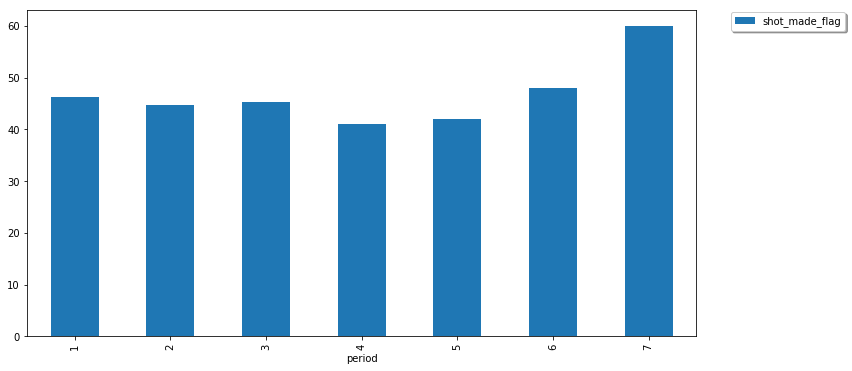

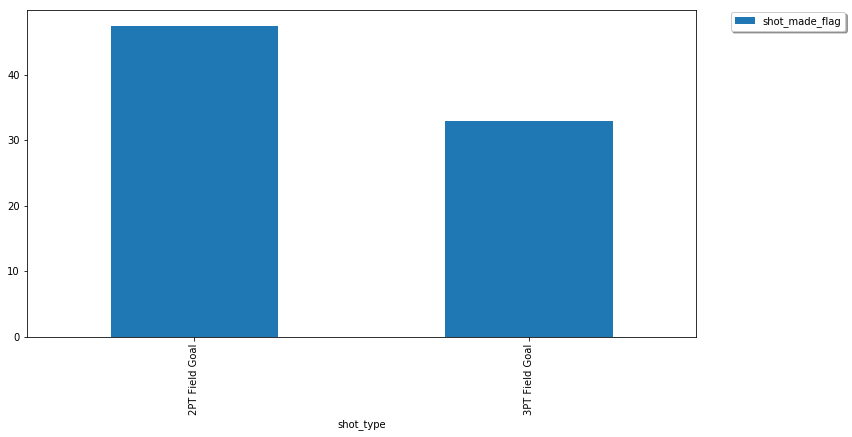

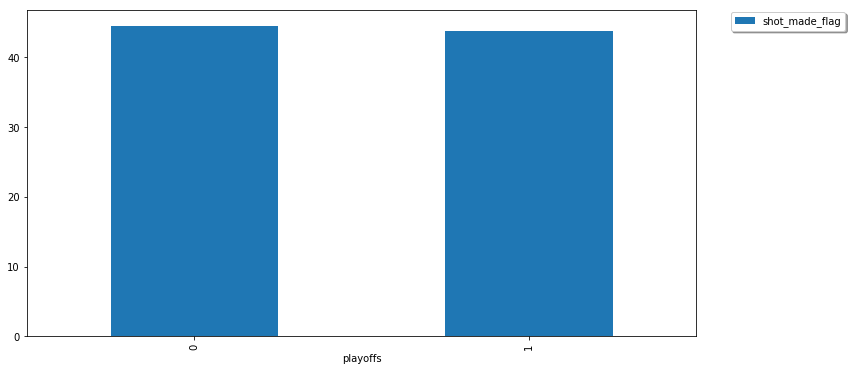

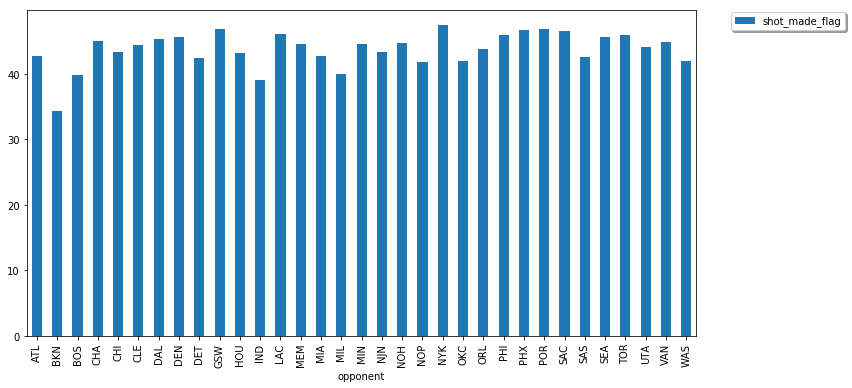

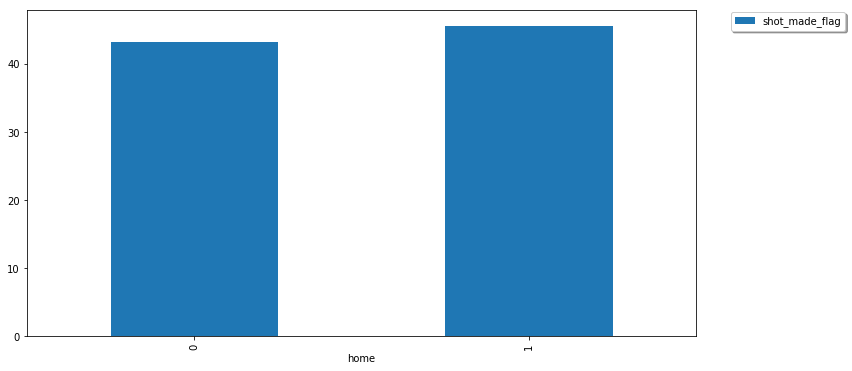

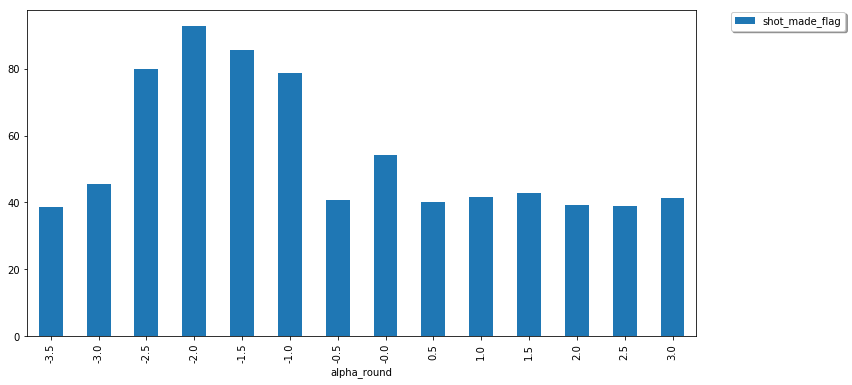

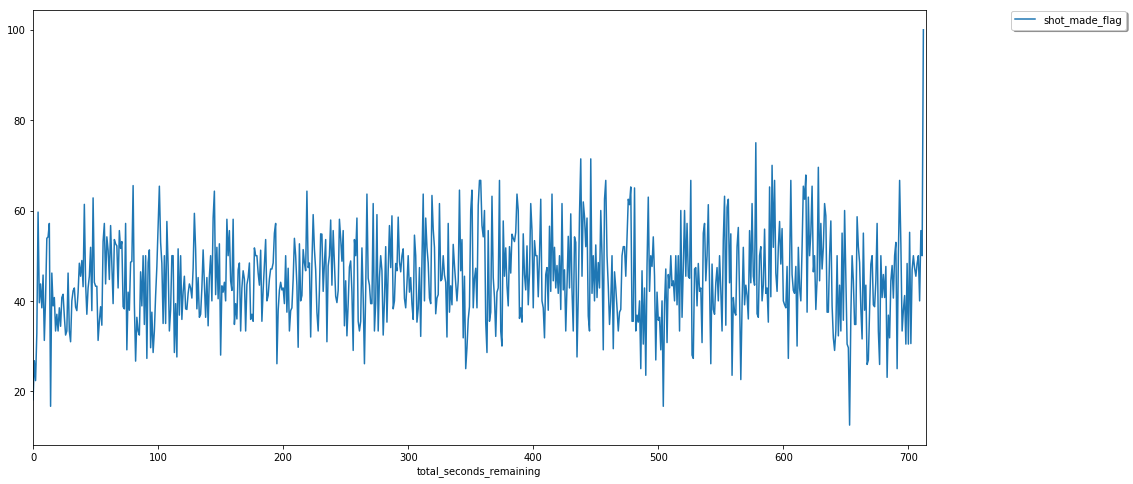

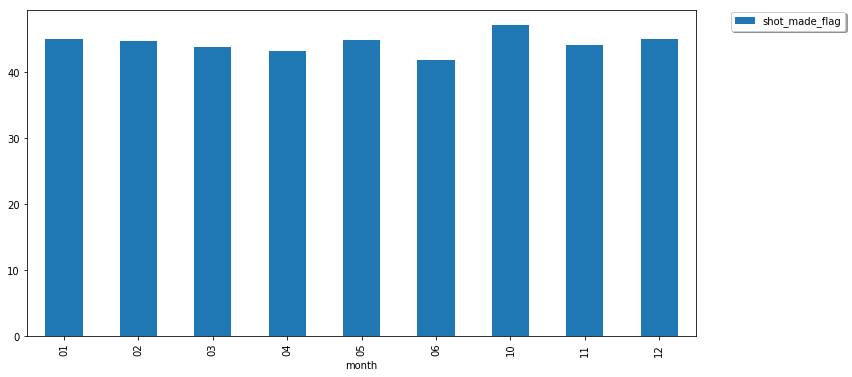

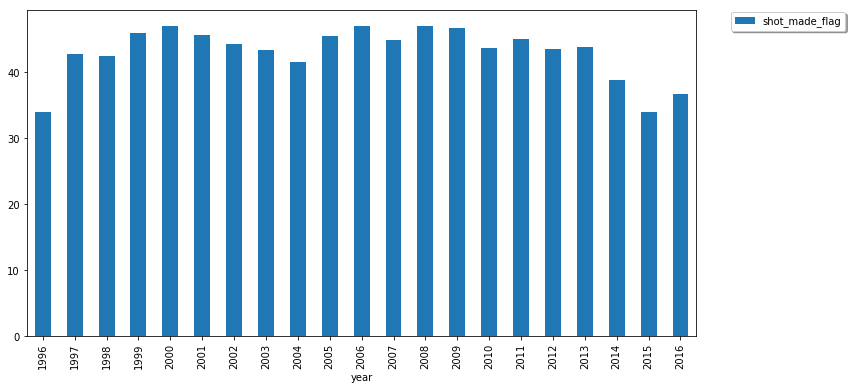

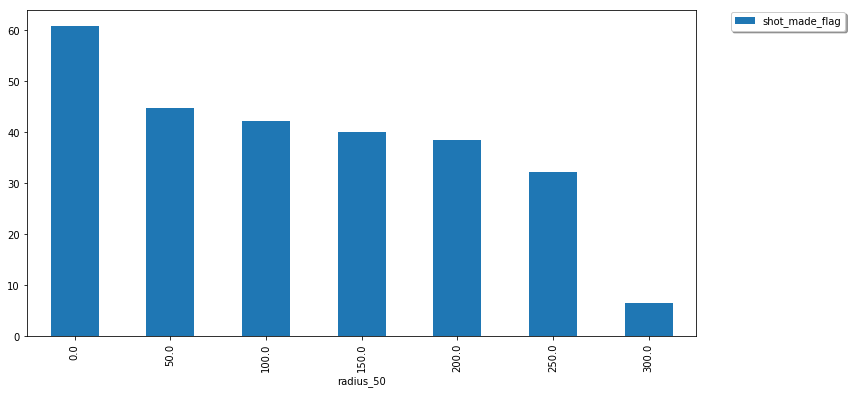

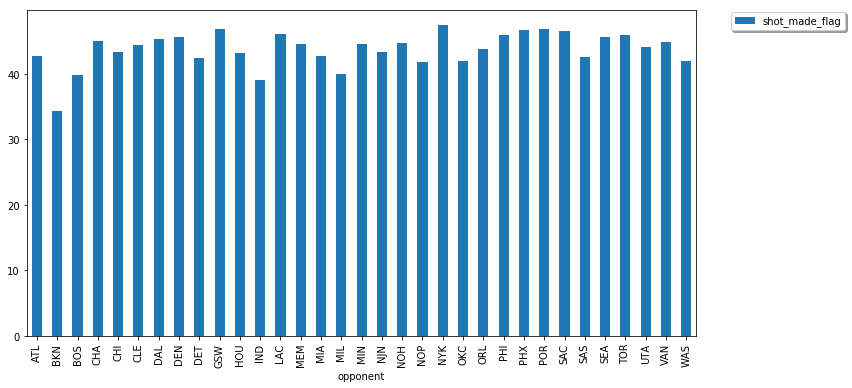

In [26]:
cols_for_hist = [
        'action_type', 'period', 'shot_type', 
        'playoffs', 'opponent', 'home',
        'alpha_round', 'total_seconds_remaining', 
        'month', 'year', 'radius_50', 'opponent',  
        ]

for col in cols_for_hist: 
    category = (
        train_df[train_df[target]==1][[col, target]].groupby(col).count()
        /
        train_df[[col, target]].groupby(col).count())*100
    
    if col != 'total_seconds_remaining':
        category.plot(legend=True, kind='bar', figsize=(12,6))
        plt.legend(loc='best', bbox_to_anchor=(1.23, 1.01), shadow=True)
    else:
        category.plot(legend=True, kind='line', figsize=(16,8))
        plt.legend(loc='best', bbox_to_anchor=(1.23, 1.01), shadow=True)

У следующих признаков точность сильно варьируется:<br>
- 'action_type'<br>
- 'alpha_round'<br>
- 'radius_50'<br>
- 'shot_type'<br>

Средняя вариация:<br>
- 'period'<br>
- 'year'<br> 

Низкая вариация:<br>
- 'opponent'<br>
- 'month'<br>
- 'playoffs'<br>
- 'home'<br>

Отдельно рассмотрим признак 'total_seconds_remaining'

In [27]:
col = 'total_seconds_remaining'
total_seconds_remaining_accuracy = (
        train_df[train_df[target]==1][[col, target]].groupby(col).count()
        /
        train_df[[col, target]].groupby(col).count())*100

In [28]:
total_seconds_remaining_accuracy.iloc[:10]

,shot_made_flag
total_seconds_remaining,
0,18.128655
1,26.760563
2,22.352941
3,32.835821
4,59.649123
5,39.583333
6,43.750000
7,38.461538
8,45.714286


Как видно в последние 3 секунды относительная точность сильно ниже средней.

In [29]:
print(f'Средняя точность: {train_df[target].mean():.2f}')

Средняя точность: 0.44


In [30]:
total_seconds_remaining_accuracy.iloc[-5:]

,shot_made_flag
total_seconds_remaining,
710,55.555556
711,50.000000
712,100.000000
713,NaN
714,66.666667


И наоборот, в первые секунды точность гораздо выше средней.

Но если посмотреть на количество бросков в последние и первые секунды, то видно, что в последние секунды 
совершается очень много попыток, в то время как в первые очень мало.

In [31]:
col = 'total_seconds_remaining'
total_seconds_remaining_count = (
        train_df[[col, target]].groupby(col).count())

In [32]:
total_seconds_remaining_count.iloc[:5]

,shot_made_flag
total_seconds_remaining,
0,342
1,142
2,85
3,67
4,57


In [33]:
total_seconds_remaining_count.iloc[-5:]

,shot_made_flag
total_seconds_remaining,
710,9
711,4
712,2
713,1
714,3


In [34]:
train_df.columns

Index(['action_type', 'game_id', 'loc_x', 'loc_y', 'period', 'playoffs',
       'season', 'shot_made_flag', 'shot_type', 'opponent', 'home',
       'total_seconds_remaining', 'field_zones', 'month', 'year', 'alpha',
       'radius', 'x20', 'y20', 'xy_zones', 'alpha_round', 'radius_50',
       'polar_zones', 'field_zones_accuracy', 'xy_zones_accuracy',
       'polar_zones_accuracy', 'last_seconds'],
      dtype='object')

In [138]:
# Категориальные признаки для преобразования в OHE
cols_to_ohe = [
    'action_type', 
    'period',  
    'shot_type',
    'field_zones',
    'month',
    'year',
    'xy_zones',
    'opponent', 
    'polar_zones',
    ]

# Количественные и бинарные признаки
cols_to_train = [
    'home', 
    'total_seconds_remaining',
    'playoffs',
    'alpha', 
    'radius',
    'loc_x', 
    'loc_y',
    'last_seconds',
    ]

In [139]:
def create_feature_df(df, cols_to_ohe, cols_to_train, train_index, test_index):
    ohe_df = pd.get_dummies(df[cols_to_ohe])
    ohe_df.columns = [col+'_ohe' for col in ohe_df.columns]
    feature_df = pd.merge(
        df[cols_to_train],
        ohe_df,
        left_index=True,
        right_index=True,
        how='inner'
    )
    feature_df = pd.merge(
        df[target],
        feature_df,
        left_index=True,
        right_index=True,
        how='inner'
    )
    train_feature_df = feature_df.iloc[train_index]
    test_feature_df = feature_df.iloc[test_index]
    
    return train_feature_df, test_feature_df

In [140]:
train_feature_df, test_feature_df = (
    create_feature_df(
        raw_df, cols_to_ohe, cols_to_train, train_index, test_index)
)

In [141]:
from sklearn.preprocessing import StandardScaler

In [142]:
def create_xy_test_train(train_feature_df, test_feature_df):
    x_train = train_feature_df.drop(['shot_made_flag'], axis=1)
    y_train = train_feature_df['shot_made_flag'].copy()
    x_test = test_feature_df.drop(['shot_made_flag'], axis=1)
    y_test = test_feature_df['shot_made_flag'].copy()
    scaler = StandardScaler()
    x_train_sc = scaler.fit_transform(x_train.astype('float64'))
    x_test_sc= scaler.transform(x_test.astype('float64'))
    
    return x_train_sc, x_test_sc, y_train, y_test

In [143]:
x_train_sc, x_test_sc, y_train, y_test = create_xy_test_train(train_feature_df, test_feature_df)

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

### Логистическая регрессия без регулиризации

In [145]:
# Т.к. в LogisticRegression регулиризация идет по умолчанию
# для того, чтобы получить близкую к нерегулиризованной модель введем
# большой к-нт С (обратный lambda)
clf_nr = LogisticRegression(penalty='l2', C=1e15, solver='liblinear')

In [146]:
clf_nr.fit(X=x_train_sc, y=y_train)

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [147]:
y_train_predict = clf_nr.predict_proba(x_train_sc)[:, 1]
y_test_predict = clf_nr.predict_proba(x_test_sc)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 5)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 5)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.73359
Test:  0.69214


In [148]:
rss = np.sum((y_test - y_test_predict)**2)
print(f'RSS = {rss:.3f}')

RSS = 1110.746


In [149]:
nr_feature_coef = pd.DataFrame(
    data=clf_nr.coef_, columns=train_feature_df.drop(['shot_made_flag'], axis=1).columns)
nr_feature_coef.insert(0, 'RSS', rss)
nr_feature_coef.insert(1, 'ROC_AUC_train',roc_auc_train)
nr_feature_coef.insert(2, 'ROC_AUC_test',roc_auc_test)
nr_feature_coef.insert(3, 'total_features', nr_feature_coef.shape[1])
nr_feature_coef.insert(4, 'null_features', nr_feature_coef.T.apply(lambda x: x==0)[0].sum())
nr_feature_coef.insert(5, 'intercept',roc_auc_test)

In [150]:
nr_feature_coef

,RSS,ROC_AUC_train,ROC_AUC_test,total_features,null_features,intercept,home,total_seconds_remaining,playoffs,alpha,...,"polar_zones_(2.5, 50.0)_ohe","polar_zones_(2.5, 100.0)_ohe","polar_zones_(2.5, 150.0)_ohe","polar_zones_(2.5, 200.0)_ohe","polar_zones_(2.5, 250.0)_ohe","polar_zones_(3.0, 0.0)_ohe","polar_zones_(3.0, 50.0)_ohe","polar_zones_(3.0, 100.0)_ohe","polar_zones_(3.0, 150.0)_ohe","polar_zones_(3.0, 200.0)_ohe"
0,1110.746061,0.73359,0.69214,658,16,0.69214,0.040919,0.027002,-0.039295,0.192768,...,-0.059623,0.017698,0.079537,0.047181,0.053361,0.016772,0.003349,0.008515,0.047648,0.035876


### Ridge регрессия

In [151]:
# Rige регрессия
clf_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=0.02)

In [152]:
clf_l2.fit(X=x_train_sc, y=y_train)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [153]:
y_train_predict = clf_l2.predict_proba(x_train_sc)[:, 1]
y_test_predict = clf_l2.predict_proba(x_test_sc)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 5)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 5)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.73308
Test:  0.69456


In [154]:
rss = np.sum((y_test - y_test_predict)**2)
print(f'RSS = {rss:.3f}')

RSS = 1099.393


In [155]:
l2_feature_coef = pd.DataFrame(
    data=clf_l2.coef_, columns=train_feature_df.drop(['shot_made_flag'], axis=1).columns)
l2_feature_coef.insert(0, 'RSS', rss)
l2_feature_coef.insert(1, 'ROC_AUC_train',roc_auc_train)
l2_feature_coef.insert(2, 'ROC_AUC_test',roc_auc_test)
l2_feature_coef.insert(3, 'total_features', l2_feature_coef.shape[1])
l2_feature_coef.insert(4, 'null_features', l2_feature_coef.T.apply(lambda x: x==0)[0].sum())
l2_feature_coef.insert(5, 'intercept',roc_auc_test)

In [156]:
l2_feature_coef

,RSS,ROC_AUC_train,ROC_AUC_test,total_features,null_features,intercept,home,total_seconds_remaining,playoffs,alpha,...,"polar_zones_(2.5, 50.0)_ohe","polar_zones_(2.5, 100.0)_ohe","polar_zones_(2.5, 150.0)_ohe","polar_zones_(2.5, 200.0)_ohe","polar_zones_(2.5, 250.0)_ohe","polar_zones_(3.0, 0.0)_ohe","polar_zones_(3.0, 50.0)_ohe","polar_zones_(3.0, 100.0)_ohe","polar_zones_(3.0, 150.0)_ohe","polar_zones_(3.0, 200.0)_ohe"
0,1099.39321,0.73308,0.69456,658,16,0.69456,0.037665,0.027315,-0.036061,0.023288,...,-0.058471,-0.009247,0.034262,0.012258,0.024483,0.034402,0.005479,-0.007839,0.021872,0.024342


### Lasso регрессия

In [157]:
# Lasso регрессия
clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.02)

In [158]:
clf_l1.fit(X=x_train_sc, y=y_train)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [159]:
y_train_predict = clf_l1.predict_proba(x_train_sc)[:, 1]
y_test_predict = clf_l1.predict_proba(x_test_sc)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 5)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 5)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.7265
Test:  0.69909


In [160]:
rss = np.sum((y_test - y_test_predict)**2)
print(f'RSS = {rss:.3f}')

RSS = 1086.139


In [161]:
l1_feature_coef = pd.DataFrame(
    data=clf_l1.coef_, columns=train_feature_df.drop(['shot_made_flag'], axis=1).columns)
l1_feature_coef.insert(0, 'RSS', rss)
l1_feature_coef.insert(1, 'ROC_AUC_train',roc_auc_train)
l1_feature_coef.insert(2, 'ROC_AUC_test',roc_auc_test)
l1_feature_coef.insert(3, 'total_features', l1_feature_coef.shape[1])
l1_feature_coef.insert(4, 'null_features', l1_feature_coef.T.apply(lambda x: x==0)[0].sum())
l1_feature_coef.insert(5, 'intercept',roc_auc_test)

In [162]:
l1_feature_coef

,RSS,ROC_AUC_train,ROC_AUC_test,total_features,null_features,intercept,home,total_seconds_remaining,playoffs,alpha,...,"polar_zones_(2.5, 50.0)_ohe","polar_zones_(2.5, 100.0)_ohe","polar_zones_(2.5, 150.0)_ohe","polar_zones_(2.5, 200.0)_ohe","polar_zones_(2.5, 250.0)_ohe","polar_zones_(3.0, 0.0)_ohe","polar_zones_(3.0, 50.0)_ohe","polar_zones_(3.0, 100.0)_ohe","polar_zones_(3.0, 150.0)_ohe","polar_zones_(3.0, 200.0)_ohe"
0,1086.139179,0.7265,0.69909,658,365,0.69909,0.021193,0.019961,0.0,0.0,...,-0.019355,-0.042534,0.0,0.0,0.0,0.012652,0.0,-0.011875,0.0,0.0


In [163]:
result = pd.concat([nr_feature_coef, l2_feature_coef, l1_feature_coef], axis=0, ignore_index=True)

In [164]:
result = result.rename({0: 'Logistic Regression', 1: 'Ridge', 2: 'Lasso'}, axis='index')

In [165]:
result.T

,Logistic Regression,Ridge,Lasso
RSS,1110.746061,1099.393210,1086.139179
ROC_AUC_train,0.733590,0.733080,0.726500
ROC_AUC_test,0.692140,0.694560,0.699090
total_features,658.000000,658.000000,658.000000
null_features,16.000000,16.000000,365.000000
intercept,0.692140,0.694560,0.699090
home,0.040919,0.037665,0.021193
total_seconds_remaining,0.027002,0.027315,0.019961
playoffs,-0.039295,-0.036061,0.000000
alpha,0.192768,0.023288,0.000000


16 нулевых признаков в Logistic Regression и Ridge судя по всему из-за отсутствующих значений в обучающем наборе. В Lasso обнулилось 365-16=349 признаков. Также заметно уменьшение к-ов в регуляризованных моделях, особенно Lasso.

Удалим некоторые из признаков с обнулившимися к-ми

In [166]:
# Т.к. в ohe признаках могли обнулится не все к-ты,
# посчитаем среднее значение ненулевых коэффицентов для каждой из групп OHE признаков.

cols_coef = {}
for col_ohe in cols_to_ohe:
    # абсолютная сумма коэф-ов
    sum_of_coef = 0
    # количество ненулевых коэф-ов в группе
    n_not_null = 0
    # общее количество коэф-ов в группе
    n = 0
    for col_coef in l1_feature_coef.columns:
        if col_ohe in col_coef:
            n+=1
            if l1_feature_coef[col_coef][0] != 0:
                n_not_null +=1
                sum_of_coef += abs(l1_feature_coef[col_coef][0])
    
    if n_not_null == 0:
        cols_coef[col_ohe] = (0, n_not_null/n*100)
    else:
        cols_coef[col_ohe] = (sum_of_coef/n_not_null, (n-n_not_null)/n*100)

In [167]:
cols_coef

{'action_type': (0.08036628218694049, 17.94871794871795),
 'period': (0.056516849545154756, 0.0),
 'shot_type': (0, 0.0),
 'field_zones': (0.01807147039976483, 50.0),
 'month': (0.009457598500697488, 55.55555555555556),
 'year': (0.02057628769906099, 23.809523809523807),
 'xy_zones': (0.009286000941113764, 59.64912280701754),
 'opponent': (0.012488533211120494, 54.54545454545454),
 'polar_zones': (0.016438466187812185, 62.121212121212125)}

In [168]:
# Для количественных и бинарных признаков
l1_feature_coef[cols_to_train]

,home,total_seconds_remaining,playoffs,alpha,radius,loc_x,loc_y,last_seconds
0,0.021193,0.019961,0.0,0.0,0.0,0.0,0.0,-0.132647


Удалим следующие признаки с нулевыми значениями коэф-ов:<br>
'shot_type', 'alpha', 'radius', <br>
'playoffs', 'loc_x', 'loc_y',<br>

Также удалим следующие группы признаков OHE в которых большое <br>
количество нулевых к-ов (>50%) и низкое среднее значение к-та:<br>
'month', 'xy_zones', 'opponent', 'polar_zones'<br>

In [169]:
# Категориальные признаки для преобразования в OHE
cols_to_ohe = [
    'action_type', 
    'period', 
    'year', 
    'field_zones',
    ]

# Количественные и бинарные признаки
cols_to_train = [
    'home', 
    'total_seconds_remaining',
    'last_seconds',
    ]

In [170]:
train_feature_df, test_feature_df = (
    create_feature_df(
        raw_df, cols_to_ohe, cols_to_train, train_index, test_index)
)
x_train_sc, x_test_sc, y_train, y_test = create_xy_test_train(train_feature_df, test_feature_df)

In [171]:
clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.05)
clf_l1.fit(X=x_train_sc, y=y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [172]:
y_train_predict = clf_l1.predict_proba(x_train_sc)[:, 1]
y_test_predict = clf_l1.predict_proba(x_test_sc)[:, 1]

In [173]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 5)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 5)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.70725
Test:  0.69614


In [174]:
rss = np.sum((y_test - y_test_predict)**2)
print(f'RSS = {rss:.3f}')

RSS = 1086.466


In [175]:
feature_coef = pd.DataFrame(data=clf_l1.coef_, columns=train_feature_df.drop(['shot_made_flag'], axis=1).columns)

In [178]:
cols_coef = {}
for col_ohe in cols_to_ohe:
    # абсолютная сумма коэф-ов
    sum_of_coef = 0
    # количество ненулевых коэф-ов в группе
    n_not_null = 0
    # общее количество коэф-ов в группе
    n = 0
    for col_coef in l1_feature_coef.columns:
        if col_ohe in col_coef:
            n+=1
            if l1_feature_coef[col_coef][0] != 0:
                n_not_null +=1
                sum_of_coef += abs(l1_feature_coef[col_coef][0])
    
    if n_not_null == 0:
        cols_coef[col_ohe] = (0, n_not_null/n*100)
    else:
        cols_coef[col_ohe] = (sum_of_coef/n_not_null, (n-n_not_null)/n*100)

In [179]:
cols_coef

{'action_type': (0.08036628218694049, 17.94871794871795),
 'period': (0.056516849545154756, 0.0),
 'year': (0.02057628769906099, 23.809523809523807),
 'field_zones': (0.01807147039976483, 50.0)}

In [180]:
feature_coef[cols_to_train]

,home,total_seconds_remaining,last_seconds
0,0.020616,0.02542,-0.148292


In [181]:
# Количество признаков:
feature_coef.shape[1]

84

In [182]:
# Количество нулевых к-ов:
feature_coef[[col for col in feature_coef.columns if feature_coef[col][0]==0]].shape[1]

10

In [183]:
# И попробуем еще xgboost

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [185]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(x_train_sc, y_train)
y_train_predict = xgb.predict_proba(x_train_sc)[:, 1]
y_test_predict = xgb.predict_proba(x_test_sc)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 3)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 3)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.738
Test:  0.7


In [186]:
rss = np.sum((y_test - y_test_predict)**2)
print(f'RSS = {rss:.3f}')

RSS = 1081.657


**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC